# Libraries

In [1]:
# pip install timm


In [2]:
import os
import torch
import torch.nn as nn
import torchvision.transforms as transforms

from timm.models.layers import DropPath, to_2tuple, trunc_normal_
from PIL import Image
import matplotlib.pyplot as plt

In [3]:
os.getcwd()

'c:\\Users\\Iman\\Google Drive\\4. BGSU\\1.2 PhD_Courses\\3. 7200_Machin Learning\\Final_project\\CS7200_SP2024_Project_G01\\Notebooks\\DDPM-Pytorch'

In [4]:
current_directory = os.getcwd()

# Concatenate the current directory with additional directories
train_dir = os.path.join(current_directory, "Data", "train")
test_dir = os.path.join(current_directory, "Data", "test")
print(train_dir)

c:\Users\Iman\Google Drive\4. BGSU\1.2 PhD_Courses\3. 7200_Machin Learning\Final_project\CS7200_SP2024_Project_G01\Notebooks\DDPM-Pytorch\Data\train


# Create Datasets and DataLoaders

In [5]:
import os

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

NUM_WORKERS = os.cpu_count()

def create_dataloaders(
    train_dir: str, 
    test_dir: str, 
    transform: transforms.Compose, 
    batch_size: int, 
    num_workers: int=NUM_WORKERS
):

  # Use ImageFolder to create dataset(s)
  train_data = datasets.ImageFolder(train_dir, transform=transform)
  test_data = datasets.ImageFolder(test_dir, transform=transform)

  # Get class names
  class_names = train_data.classes

  # Turn images into data loaders
  train_dataloader = DataLoader(
      train_data,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      pin_memory=True,
  )
  test_dataloader = DataLoader(
      test_data,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      pin_memory=True,
  )

  return train_dataloader, test_dataloader, class_names

In [6]:
# Create image size
IMG_SIZE = 224

# Create transform pipeline manually
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])           
print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
    ToTensor()
)


In [7]:
# Set the batch size
BATCH_SIZE = 32 

# Create data loaders
train_dataloader, test_dataloader, class_names = create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms, 
    batch_size=BATCH_SIZE
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x19a0dc75950>,
 ['COVID', 'NORMAL', 'PNEUMONIA'])

torch.Size([3, 224, 224]) tensor(0)


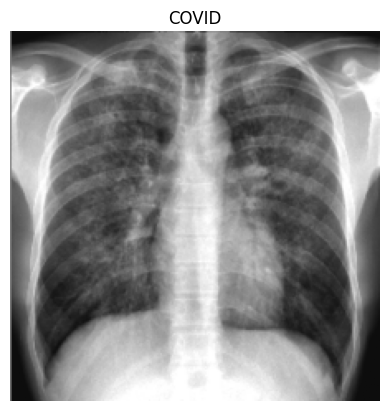

In [8]:
# Let's visualize a image in order to know if data is loaded properly or not

# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image from the batch
image, label = image_batch[0], label_batch[0]

# View the batch shapes
print(image.shape, label)

# Plot image with matplotlib
plt.imshow(image.permute(1, 2, 0)) # rearrange image dimensions to suit matplotlib [color_channels, height, width] -> [height, width, color_channels]
plt.title(class_names[label])
plt.axis(False);

In [10]:
from swin_functions_and_classes import *
model = SwinTransformer(num_classes=len(class_names))

In [15]:
from going_modular.going_modular import engine
from helper_functions import set_seeds

device = "cuda" if torch.cuda.is_available() else "cpu"
device

# Setup the optimizer to optimize our ViT model parameters using hyperparameters from the ViT paper 
optimizer = torch.optim.Adam(params=model.parameters(), 
                             lr=3e-3, # Base LR from Table 3 for ViT-* ImageNet-1k
                             betas=(0.9, 0.999), # default values but also mentioned in ViT paper section 4.1 (Training & Fine-tuning)
                             weight_decay=0.3) # from the ViT paper section 4.1 (Training & Fine-tuning) and Table 3 for ViT-* ImageNet-1k

# Setup the loss function for multi-class classification
loss_fn = torch.nn.CrossEntropyLoss()

# Set the seeds
set_seeds()

# Train the model and save the training results to a dictionary
results = engine.train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=64,
                       device=device)



  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.2329 | train_acc: 0.3566 | test_loss: 1.4507 | test_acc: 0.3125
Epoch: 2 | train_loss: 1.1687 | train_acc: 0.3421 | test_loss: 1.2981 | test_acc: 0.3125
Epoch: 3 | train_loss: 1.1491 | train_acc: 0.3526 | test_loss: 1.1559 | test_acc: 0.3125
Epoch: 4 | train_loss: 1.1494 | train_acc: 0.3277 | test_loss: 1.1382 | test_acc: 0.3750
Epoch: 5 | train_loss: 1.1274 | train_acc: 0.3454 | test_loss: 1.1987 | test_acc: 0.3125
Epoch: 6 | train_loss: 1.1162 | train_acc: 0.3438 | test_loss: 1.1096 | test_acc: 0.3125


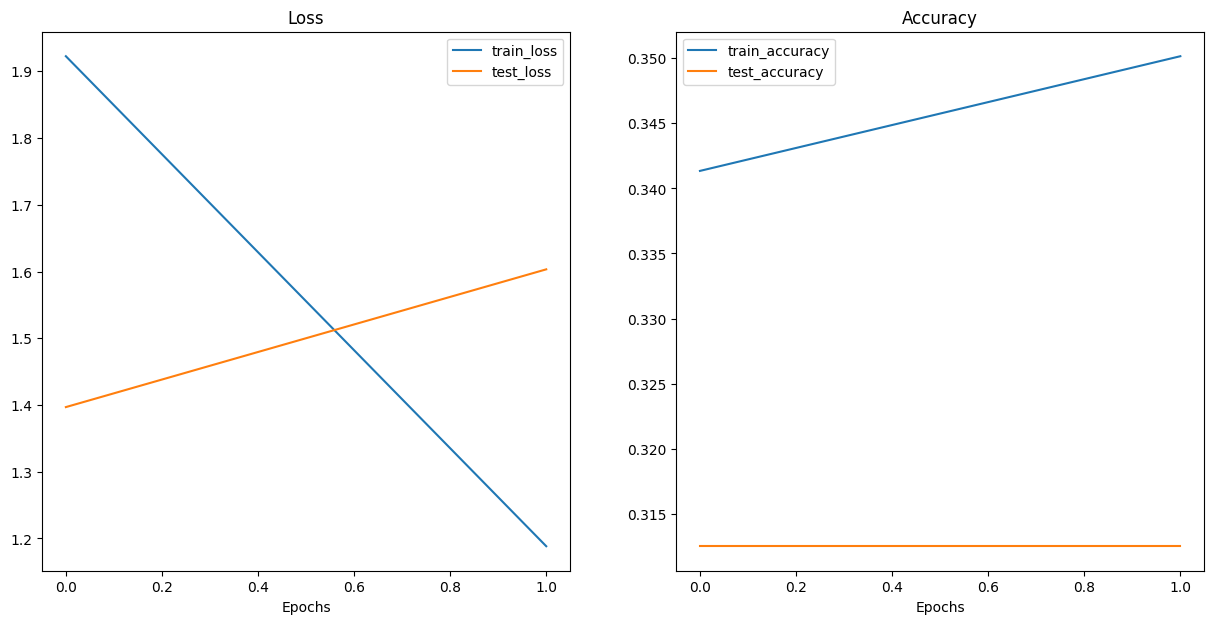

In [12]:
# To check out our ViT model's loss curves, we can use the plot_loss_curves function from helper_functions.py
from helper_functions import plot_loss_curves

# Plot our ViT model's loss curves
plot_loss_curves(results)

# save results

In [ ]:
import pickle

with open('training_results.pkl', 'wb') as f:
    pickle.dump(results, f)

# ## Load results
# with open('training_results.pkl', 'rb') as f:
#     loaded_results = pickle.load(f)

# Prediction

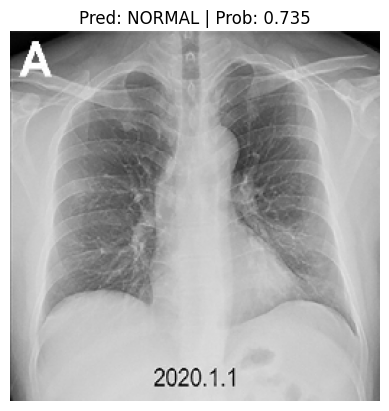

In [14]:
import requests

# Import function to make predictions on images and plot them 
from going_modular.going_modular.predictions import pred_and_plot_image

# Setup custom image path
custom_image_path = "COVID_201.png"

# Predict on custom image
pred_and_plot_image(model=model,
                    image_path=custom_image_path,
                    class_names=class_names)